In [ ]:
# 导入环境
import os, sys
current_path = os.path.abspath(os.path.dirname('.'))  # 获取文件目录
project_path = current_path[:current_path.find('RIGEL') + len('RIGEL')]  # 获取项目根路径，内容为当前项目的名字，即RIGEL
sys.path.append(project_path)  # 将项目根路径添加到系统路径中，以便导入项目中的模块

result_dir = f'{project_path}/results'  # 用于存放结果的目录

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # 进度条库
from src import Dynamics, Activation, ESN, VISION, Dataset_makeup

定义要学习的动态系统

In [7]:

num_step = 10001  # 总步数
step_length = 0.01
time, data = Dynamics.Lorenz_63(origin=(3,2,16),parameter=(10,28,8.0/3.0),num_step=num_step,step_length=step_length)

# data = Dynamics.Add_noise(data, SNR=20.)  # 加入噪声

num_init = 2000  # 前面的点可能包含初始点的信息，会是我们的拟合偏移，因此我们从一定点数之后开始取值
num_train = 4000  # 训练集长度
num_test = 3000  # 预测集长度
initialization_set, training_set, testing_set = Dataset_makeup(time, data,num_init=num_init, num_train=num_train, num_test=num_test)

t_init, x_init, y_init = initialization_set
t_train, x_train, y_train = training_set
t_test, x_test, y_test = testing_set

定义ESN网络，并对于目标系统进行学习预测

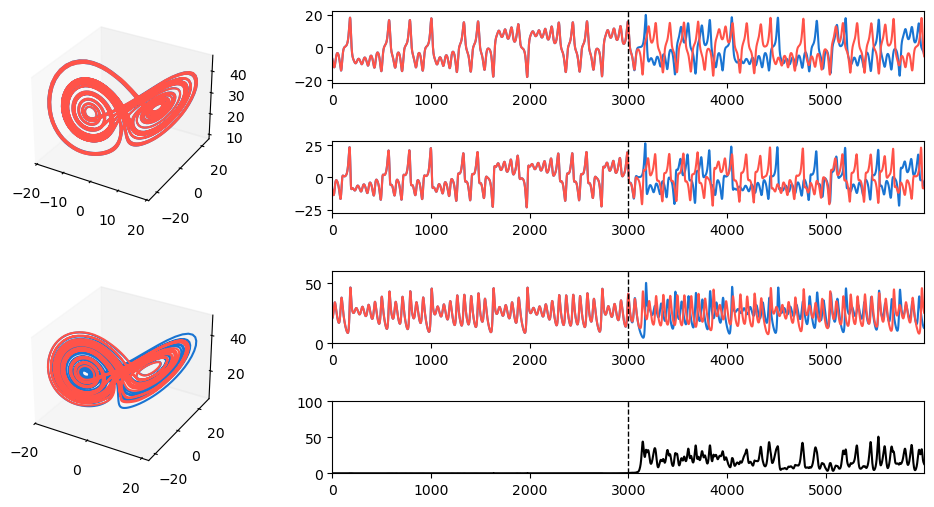

In [ ]:
# NOTE: 定义一些常用的网络参数
input_scaling = 0.25  # 如果计算结果出现nan，则可以考虑先降低输入的缩放因子，因为我们的激活函数是无界函数，很容易超出计算机所能处理的量程
leaking_rate = 0.95
# NOTE: 水库权重矩阵的参数
reservoir_dim = 400  # N是水库矩库的边长，同时也就是水库态向量的长度
spectral_radius = 1.2
reservoir_density = 0.05
# 器件的性能的多项式拟合系数
# device_coefficient = [0, -0.0606270243, 0.00364103237, 0.140685043, 0.00988703156, -0.00824646444,
# -0.000618645284, 0.000257831028, 0.000011526794, -0.00000315380367]
# reference_factor = 0.65
transient = 1000

def act_func(x): return Activation.I_Taylor_w_OperationalRange(x, operational_range=(-3,3))  # 激活函数，考虑了器件的非理想特性

model = ESN.Analog_LiESN(input_dimension=3,output_dimension=3,
                        input_scaling=input_scaling,
                        # activation=Activation.I_Taylor,  # Ideal device charateristics
                        # activation=Activation.I_Taylor_w_deviation,  # Considering device variation
                        activation=act_func,
                        leaking_rate=leaking_rate,
                        reservoir_dimension=reservoir_dim,
                        reservoir_density=reservoir_density,
                        reservoir_spectral_radius=spectral_radius,
                        # reservoir_connection_weight=W_res,
                        transient=transient,
                        bias=0)

# opt_algorithm=4的SelectKBest算法有奇效，太过夸张，慎用！！！主要是岭回归（opt_algorithm=2）效果太好！！！
y_train_ESN, y_train, u_state_train, r_state_train, W_out = model.Training_phase(x_train, y_train, opt_algorithm=2)
# 此模型可以利用transient参数先把前面一段储层的初始态去掉
t_train_new = np.array([i + num_init + transient for i in range(y_train.shape[1])])

y_test_ESN, u_state_test, r_state_test = model.Predicting_phase(num_test)

# 网络拟合结果分析
VISION.Analyze_3D_systems(np.hstack((t_train_new, t_test)), (y_train, y_train_ESN), (y_test, y_test_ESN), deviation_range=(0, 100))

plt.show(block=True)

# Lyapunov谱分析
# Evaluation.Quick_LyapunovAnalysis(y_test,y_test_ESN,mean_period=10,num_step=2000,step_length=step_length,
                                    # estimate_steps_truth=200,estimate_steps_network=200,
                                    # filename='Lorenz',
                                    # saving_directory='E:/PhD_research/NonlinearNode_for_InformationSecurity/Manuscript_Theory/补充数据')